<a href="https://colab.research.google.com/github/yuvasreekrishnan/codecraft/blob/main/sentimentanalysisnm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


✓ Loaded with latin1


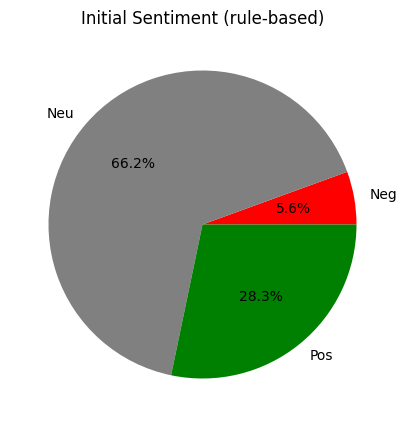

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2110
     Neutral       1.00      1.00      1.00     25129
    Positive       1.00      1.00      1.00     10736

    accuracy                           1.00     37975
   macro avg       1.00      1.00      1.00     37975
weighted avg       1.00      1.00      1.00     37975

Accuracy: 0.999


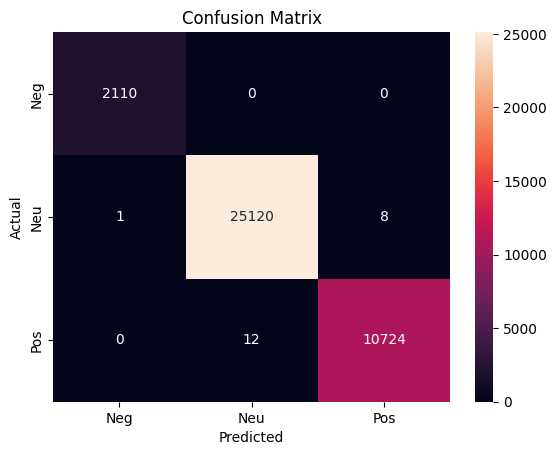

✓ Model & vectorizer saved to /content/
Amazing phone, loved the camera! → Positive
Worst battery life ever. → Negative
It's okay for the price. → Neutral


In [ ]:
# ============================================================
#  ★ Sentiment‑Analysis Pipeline for Flipkart Reviews (Colab)
# ============================================================

# ---------- 1. Install / import libraries ----------
!pip install -q seaborn scikit-learn joblib nltk

import pandas as pd, zipfile, re, joblib, nltk, matplotlib.pyplot as plt, seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ---------- 2. [Optional] Mount Google Drive ----------
# from google.colab import drive
# drive.mount('/content/drive')

# ---------- 3. Download NLTK resources ----------
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# ---------- 4. Helper: load zipped CSV safely ----------
def load_zip_csv(zip_path: str) -> pd.DataFrame:
    """Extract first CSV inside zip & read it with best‑effort encoding."""
    with zipfile.ZipFile(zip_path) as zf:
        csv_name = zf.namelist()[0]
        zf.extract(csv_name, "/content/")
    encodings = ["utf-8", "latin1", "ISO‑8859‑1", "cp1252"]
    for enc in encodings:
        try:
            df = pd.read_csv(f"/content/{csv_name}", encoding=enc)
            print(f"✓ Loaded with {enc}")
            return df
        except UnicodeDecodeError:
            continue
    print("⚠️  Falling back to utf‑8 with replacement.")
    return pd.read_csv(f"/content/{csv_name}", encoding="utf-8", errors="replace")

# ---------- 5. Text preprocessing ----------
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)         # links
    text = re.sub(r"@\w+|#", "", text)                          # @, #
    text = re.sub(r"[^\w\s]", "", text)                         # punct
    tokens = [
        lemmatizer.lemmatize(w) for w in text.split()
        if w not in stop_words
    ]
    return " ".join(tokens)

# ---------- 6. Rule‑based seed sentiment ----------
pos_words = ["good","great","excellent","perfect","amazing",
             "love","happy","awesome","fantastic","wonderful"]
neg_words = ["bad","poor","terrible","awful","horrible",
             "hate","worst","disappointing","rubbish","waste"]

def rule_sentiment(text: str) -> int:
    t = str(text).lower()
    p = sum(w in t for w in pos_words)
    n = sum(w in t for w in neg_words)
    return 2 if p>n else 0 if n>p else 1   # 2=Pos,1=Neutral,0=Neg

# ---------- 7. Load your dataset ZIP ----------
ZIP_PATH = "/content/flipkart_product.csv.zip"  # <-- change if needed
df = load_zip_csv(ZIP_PATH)

# Ensure a column named 'Review' exists
if "Review" not in df.columns:
    raise KeyError("Column 'Review' not found!")

# ---------- 8. Preprocess + label ----------
df["processed"] = df["Review"].apply(preprocess)
df["sentiment"] = df["Review"].apply(rule_sentiment)

# ---------- 9. Quick distribution plot ----------
plt.figure(figsize=(5,5))
df["sentiment"].value_counts().sort_index()\
   .plot.pie(labels=["Neg","Neu","Pos"],
             autopct="%1.1f%%", colors=["red","gray","green"])
plt.title("Initial Sentiment (rule‑based)")
plt.ylabel("")
plt.show()

# ----------10. Train / test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    df["processed"], df["sentiment"],
    test_size=0.2, stratify=df["sentiment"], random_state=42
)

# ----------11. Vectorise & train ----------
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
Xtr = tfidf.fit_transform(X_train)
Xts = tfidf.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(Xtr, y_train)

# ----------12. Evaluation ----------
yp = model.predict(Xts)
print(classification_report(y_test, yp, target_names=["Negative","Neutral","Positive"]))
print("Accuracy:", round(accuracy_score(y_test, yp), 3))

cm = confusion_matrix(y_test, yp)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Neg","Neu","Pos"],
            yticklabels=["Neg","Neu","Pos"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()

# ----------13. Save artefacts ----------
joblib.dump(model, "/content/sentiment_model.pkl")
joblib.dump(tfidf, "/content/tfidf_vectorizer.pkl")
print("✓ Model & vectorizer saved to /content/")

# ----------14. Predict helper ----------
def predict_sentiment(text: str) -> str:
    vec = tfidf.transform([preprocess(text)])
    cls = model.predict(vec)[0]
    return ["Negative","Neutral","Positive"][cls]

# Demo
for r in ["Amazing phone, loved the camera!",
          "Worst battery life ever.",
          "It's okay for the price."]:
    print(r, "→", predict_sentiment(r))
